***Data Pre-Processor***


In [1]:
%run DeepFake_Dataloader.py
%run utils.py

In [2]:
import h5py
import torch
import numpy as np

In [3]:
batch_sz = 128 
dataloader = get_preprocessors(batch_size=batch_sz)
total_imgs = len(dataloader) * batch_sz
print(total_imgs)
total_imgs = !find {img_root} -type f -iname "*.png" | wc -l
total_imgs = int(total_imgs[0])
print(total_imgs)

('Classes: '
 "['lsun_bedrooms', "
 "'lsun_cats', "
 "'lsun_churches', "
 "'stylegan1_bedrooms', "
 "'stylegan2_cats', "
 "'stylegan2_churches']")
('Indices: '
 "{'lsun_bedrooms': "
 "0, 'lsun_cats': "
 '1, '
 "'lsun_churches': "
 '2, '
 "'stylegan1_bedrooms': "
 '3, '
 "'stylegan2_cats': "
 '4, '
 "'stylegan2_churches': "
 '5}')
60032
60002


In [4]:
progress = ProgressMonitor(length=total_imgs)
rad_len  = 182
with h5py.File('LSUN_BCC_256.hdf5', 'w') as f:
    """
        Create HDF5 datasets 
    """
    data_dset = f.create_dataset('fft_data',  (total_imgs, rad_len), dtype='f')
    lbl_dset  = f.create_dataset('lbl_data',  (total_imgs,),     dtype='i')
    orgn_dset = f.create_dataset('orgn_data', (total_imgs,),     dtype='i')
    img_size  = f.create_dataset('img_size',  (total_imgs,),     dtype='i')
    data_size = f.create_dataset('data_size', (total_imgs,),     dtype='i')
    
    for i, (img_data, target, origin_dataset) in enumerate(dataloader):
        start_idx = i * batch_sz
        for j in range(img_data.shape[0]):
            idx = start_idx + j
            progress.update(1, 0)
            if (target[j] > 1):
                print(target[j])
            data_dset[idx] = img_data[j]
            lbl_dset[idx]  = target[j]
            orgn_dset[idx] = data_origin[origin_dataset[j]]
            img_size[idx]  = data_img_size[origin_dataset[j]]
            data_size[idx] = rad_size[origin_dataset[j]]
        

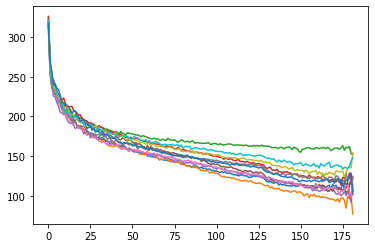

In [16]:
import matplotlib.pyplot as plt


with h5py.File('LSUN_BCC_256.hdf5.1', 'r') as f:
    dset = f['fft_data']
    plt.plot(dset[200])
    for i in range(10):
        plt.plot(dset[np.random.randint(20000)])
#         plt.show()
    plt.show()

In [6]:
with h5py.File('LSUN_Cars.hdf5', 'r') as f:
    dset = f['lbl_data']
    for i in range(len(dset)):
        if dset[i] != 1 and dset[i] != 0:
            print(dset[i])

In [13]:
!gcloud auth activate-service-account --key-file ./playground-270702-4d2df0765336.json

Activated service account credentials for: [1091534425226-compute@developer.gserviceaccount.com]


In [14]:
# auth.authenticate_user()

project_id = 'playground-270702'
!gcloud config set project {project_id}
!gsutil ls

bucket_name = 'img-hosting-bucket'
!gsutil -m cp -r /home/jupyter/CSE253_FinalProject/LSUN_BCC_256.hdf5 gs://{bucket_name}/

Updated property [core/project].
gs://img-hosting-bucket/
Copying file:///home/jupyter/CSE253_FinalProject/LSUN_BCC_256.hdf5 [Content-Type=application/octet-stream]...
- [1/1 files][ 42.6 MiB/ 42.6 MiB] 100% Done                                    
Operation completed over 1 objects/42.6 MiB.                                     


In [15]:
!wget https://storage.googleapis.com/img-hosting-bucket/LSUN_BCC_256.hdf5

--2020-03-14 03:43:02--  https://storage.googleapis.com/img-hosting-bucket/LSUN_BCC_256.hdf5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44643976 (43M) [application/octet-stream]
Saving to: ‘LSUN_BCC_256.hdf5.1’

LSUN_BCC_256.hdf5.1 100%[===================>]  42.58M  78.8MB/s    in 0.5s    

2020-03-14 03:43:03 (78.8 MB/s) - ‘LSUN_BCC_256.hdf5.1’ saved [44643976/44643976]

